2021-08-29 23:26:12,198 numexpr.utils [INFO] NumExpr defaulting to 6 threads.
2000-02-29 00:00:00 strategy [INFO] buying at 92.4446029663086, which is above 91.45763046264649
2000-03-01 00:00:00 strategy [INFO] ===== BUY at 92.57077439008933 10600 =====
2000-09-29 00:00:00 strategy [INFO] selling at 97.32402038574219, which is below 97.80041191101083
2000-10-02 00:00:00 strategy [INFO] ===== SELL at 97.7687285326109 =====
2002-03-28 00:00:00 strategy [INFO] buying at 79.06106567382812, which is above 78.55213935852052
2002-04-01 00:00:00 strategy [INFO] ===== BUY at 78.86080486097262 13078 =====
2002-04-30 00:00:00 strategy [INFO] selling at 74.46324157714844, which is below 77.77585090637213
2002-05-01 00:00:00 strategy [INFO] ===== SELL at 74.53911277995648 =====
2003-04-30 00:00:00 strategy [INFO] buying at 64.53276824951172, which is above 61.537537994384785
2003-05-01 00:00:00 strategy [INFO] ===== BUY at 64.53981234295006 15164 =====
2007-12-31 00:00:00 strategy [INFO] selling at

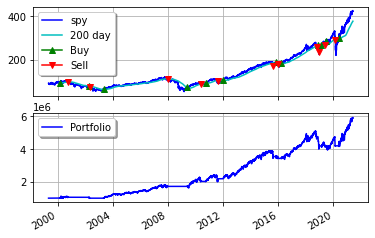

Final portfolio value: $5920683.91
Cumulative returns: 492.07 %
Max. drawdown: 22.44 %
Longest drawdown duration: 1253 days, 0:00:00

Total trades: 11
Avg. profit: $290521
Profits std. dev.: $573661
Max. profit: $1355309
Min. profit: $-554678
Avg. return: 17 %
Returns std. dev.: 27 %
Max. return: 74 %
Min. return: -12 %

Profitable trades: 7
Avg. profit: $567912
Profits std. dev.: $529725
Max. profit: $1355309
Min. profit: $55098
Avg. return: 30 %
Returns std. dev.: 27 %
Max. return: 74 %
Min. return:  1 %

Unprofitable trades: 4
Avg. loss: $-194913
Losses std. dev.: $208859
Max. loss: $-554678
Min. loss: $-56519
Avg. return: -5 %
Returns std. dev.:  4 %
Max. return: -1 %
Min. return: -12 %


In [20]:
import pandas
import pandas_market_calendars as market_calendar

from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns, drawdown, trades

# get last days of month
nyse = market_calendar.get_calendar('NYSE')
df = nyse.schedule(start_date='2000-01-01', end_date='2021-12-31')
df = df.groupby(df.index.strftime('%Y-%m')).tail(1)
df['date'] = pandas.to_datetime(df['market_open']).dt.date
last_days_of_month = [date.isoformat() for date in df['date'].tolist()]

class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MovingAverageStrategy, self).__init__(feed)
        self.instrument = instrument
        self.position = None
        self.ma = ma.SMA(feed[instrument].getAdjCloseDataSeries(), 200)
        self.setUseAdjustedValues(True)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f"===== BUY at {execInfo.getPrice()} {execInfo.getQuantity()} =====")

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f"===== SELL at {execInfo.getPrice()} =====")
        self.position = None
    
    def onBars(self, bars):
        if self.ma[-1] is None:
            return

        bar = bars[self.instrument]
        close = bar.getAdjClose()
        date = bar.getDateTime().date().isoformat()

        if date in last_days_of_month:
            if self.position is None:
                broker = self.getBroker()
                cash = broker.getCash() * .98
                
                if date in last_days_of_month and close > self.ma[-1]:
                    quantity = cash / close
                    self.info(f"buying at {close}, which is above {self.ma[-1]}")
                    self.position = self.enterLong(self.instrument, quantity)
            
            elif close < self.ma[-1] and self.position is not None:
                self.info(f"selling at {close}, which is below {self.ma[-1]}")
                self.position.exitMarket()
                self.position = None


# # Load the bar feed from the CSV file
feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")

strategy = MovingAverageStrategy(feed, "spy")

returnsAnalyzer = returns.Returns()
tradesAnalyzer = trades.Trades()
drawDownAnalyzer = drawdown.DrawDown()

strategy.attachAnalyzer(returnsAnalyzer)
strategy.attachAnalyzer(drawDownAnalyzer)
strategy.attachAnalyzer(tradesAnalyzer)

plt = plotter.StrategyPlotter(strategy) 
plt.getInstrumentSubplot("spy").addDataSeries("200 day", strategy.ma)

strategy.run()

plt.plot()

print("Final portfolio value: $%.2f" % strategy.getResult())
print("Cumulative returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))
print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getAllReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("Avg. profit: $%2.f" % (profits.mean()))
    print("Profits std. dev.: $%2.f" % (profits.std()))
    print("Max. profit: $%2.f" % (profits.max()))
    print("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getPositiveReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

print("")
print("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("Avg. loss: $%2.f" % (losses.mean()))
    print("Losses std. dev.: $%2.f" % (losses.std()))
    print("Max. loss: $%2.f" % (losses.min()))
    print("Min. loss: $%2.f" % (losses.max()))
    returns = tradesAnalyzer.getNegativeReturns()
    print("Avg. return: %2.f %%" % (returns.mean() * 100))
    print("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print("Max. return: %2.f %%" % (returns.max() * 100))
    print("Min. return: %2.f %%" % (returns.min() * 100))

